# 多尺度目标检测

In [2]:
%matplotlib inline
import torch
from d2l import torch as d2l

img = d2l.plt.imread(r"../data/catdog.jpg")
h, w = img.shape[:2]
h, w

(561, 728)

在特征图（fmap，某一个卷积层的输出）上生成锚框（anchors），每个单位像素作为锚框中心

In [8]:
def display_anchors(fmap_w, fmap_h, s):
    # s*s表示为占比，占的图片大小
    # 每个像素为中心生成锚框
    d2l.set_figsize()
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    # anchors生成的是0-1数值
    anchors = d2l.multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    # scale是换算成现在的图片大小
    bbox_scale = torch.tensor((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img).axes, 
                    anchors[0] * bbox_scale)

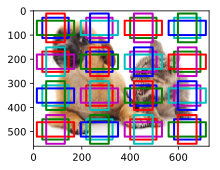

In [9]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15]) # feature map是4x4，返回原始图片就不一样了

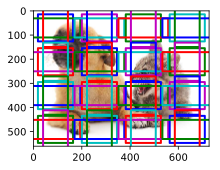

In [14]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.2])

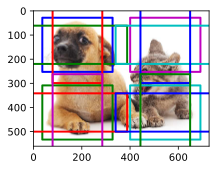

In [10]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.4]) # feature map很小的时候，可以选择更大的size，做比较大的锚框

# 单发多框检测 (SSD)

In [25]:
import pandas as pd

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import pandas as pd

# 类别预测层
def cls_predictor(num_inputs, num_anchors, num_classes):
    # +1表示背景类
    # 对每一个锚框都是多少类
    # 不是全连接，用卷积做分类器，多少类是多少通道
    # 这里没有像以前用average pooling
    # num_anchors数量 = 像素个数 * 每个像素的锚框数
    # 要对每个像素做很多预测
    return nn.Conv2d(num_inputs, num_anchors * (num_classes + 1),
                     kernel_size=3, padding=1)

边界框预测层

In [2]:
def bbox_predictor(num_inputs, num_anchors):
    # 去预测和真实bounding box的offset
    # offset有4个值
    return nn.Conv2d(num_inputs, num_anchors * 4, 
                     kernel_size=3, padding=1)

连接多尺度的预测

In [3]:
def forward(x, block):
    return block(x)

# 不一样的feature map
# 8:input channels
# 5:anchor nums
# 10:class nums
# (2, 55, 20, 20): 2是batch_size, 55=11classes * 5anchor nums；后面20 x 20对应每个像素
Y1 = forward(torch.zeros((2, 8, 20, 20)), cls_predictor(8, 5, 10))
Y2 = forward(torch.zeros((2, 16, 10, 10)), cls_predictor(16, 3, 10))
Y1.shape, Y2.shape
# 不同尺度下的预测，除了batch size是一样的，其他都不相同

(torch.Size([2, 55, 20, 20]), torch.Size([2, 33, 10, 10]))

In [6]:
# 拉直再，合并一起
def flatten_pred(pred):
    # 1、把通道数丢到最后 - 希望每个像素的预测值在flatten后，是一个连续排列的
    # 2、start_dim=1，把后面三个维度的拉成一个向量
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(p) for p in preds], dim=1)

# 所有预测都放在一个维度
concat_preds([Y1, Y2]).shape

torch.Size([2, 25300])

高和宽减半块

In [4]:
def down_sample_blk(in_channels, out_channels):
    blk = []
    for _ in range(2):
        blk.append(
            nn.Conv2d(in_channels, out_channels,kernel_size=3, padding=1)
        )
        blk.append(nn.BatchNorm2d(out_channels))
        blk.append(nn.ReLU())
        in_channels = out_channels
    blk.append(nn.MaxPool2d(2)) 
    # window size=2，默认padding size下，能够高宽减半
    return nn.Sequential(*blk)


forward(torch.zeros((2, 3, 20, 20)),
        down_sample_blk(3, 10)).shape

torch.Size([2, 10, 10, 10])

基本网络块 - 从原始图片抽特征，到第一次要选取锚框之间

In [5]:
def base_net():
    blk = []
    num_filters = [3, 16, 32, 64]
    for i in range(len(num_filters) - 1):
        blk.append(down_sample_blk(num_filters[i], num_filters[i+1]))
    return nn.Sequential(*blk)

forward(torch.zeros((2, 3, 256, 256)), base_net()).shape

torch.Size([2, 64, 32, 32])

完整的单发多框检测模型由五个模块组成

In [7]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveAvgPool2d((1, 1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

为每个块定义前向计算

In [16]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X) # stage的feature map
    # 其实可以写在外面，锚框只关心Y的高和宽
    anchors = d2l.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y) # 只要知道有多少个锚框就可以了
    bbox_preds = bbox_predictor(Y) # 只要知道有多少个锚框就可以了
    # forward不用管具体锚框是怎么样，算loss时候才要用到锚框
    return (Y, anchors, cls_preds, bbox_preds)

超参数

In [13]:
sizes = [[0.2, 0.272],
         [0.37, 0.447],
         [0.54, 0.619],
         [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

定义完整的模型

In [14]:
class TinySSD(nn.Module):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        idx_to_in_channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', 
                    cls_predictor(idx_to_in_channels[i], 
                                  num_anchors, num_classes))
            setattr(self, f'bbox_{i}',
                    bbox_predictor(idx_to_in_channels[i], num_anchors))
    
    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i], 
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}')
            )
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        # 方便进行softmax
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, 
                                      self.num_classes+1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

实例

In [17]:
net = TinySSD(num_classes=1)
X = torch.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print("output anchors:", anchors.shape) # 不管批量多大，anchors第一维都是1
print("output class preds:", cls_preds.shape)
print("output bbox preds:", bbox_preds.shape) # 5444 * 4

/usr/local/lib/python3.7/dist-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
output anchors: torch.Size([1, 5444, 4])
output class preds: torch.Size([32, 5444, 2])
output bbox preds: torch.Size([32, 21776])


读取香蕉数据集

In [23]:
# 香蕉数据集
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')
#@save
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if 
                is_train else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' 
                         if is_train else 'bananas_val', 
                         'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256


class BananasDataset(torch.utils.data.Dataset):
    """一个用于加载香蕉检测数据的自定义数据集"""
    def  __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print("read" + str(len(self.features)) + (
            f' training examples' if is_train else f' validation examples'))
    
    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])
    
    def __len__(self):
        return len(self.features)

def load_data_bananas(batch_size):
    """加载香蕉检测数据集"""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True), batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False), batch_size)
    return train_iter, val_iter

In [26]:
batch_size = 32
train_iter, _ = load_data_bananas(batch_size)

read1000 training examples
read100 validation examples


In [30]:
device, net = d2l.try_gpu(), TinySSD(num_classes=1)
trainer = torch.optim.SGD(net.parameters(), lr=0.2, weight_decay=5e-4)

定义损失函数

In [35]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none') # L1降低异常值的影响

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes), # 批量大小和锚框合并
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    # masks：觉得是背景框的时候，不预测便宜
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

def cls_eval(cls_preds, cls_labels):
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

模型训练

class err 3.23e-03, bbox mae 3.05e-03
2856.6 examples/sec on cuda:0


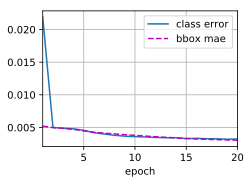

In [36]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                        legend=['class error', 'bbox mae'])
net = net.to(device)
for epoch in range(num_epochs):
    # 训练精确度的和，训练精确度的和中的示例数
    # 绝对误差的和，绝对误差的和中的示例数
    metric = d2l.Accumulator(4)
    net.train()
    for features, target in train_iter:
        timer.start()
        trainer.zero_grad()
        X, Y = features.to(device), target.to(device)
        # 生成多尺度的锚框，为每个锚框预测类别和偏移量
        anchors, cls_preds, bbox_preds = net(X)
        # 为每个锚框标注类别和偏移量
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, Y)
        # 根据类别和偏移量的预测和标注值计算损失函数
        l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                      bbox_masks)
        l.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')

预测目标

In [37]:
X = torchvision.io.read_image("../data/banana.jpg").unsqueeze(0).float()
img = X.squeeze(0).permute(1, 2, 0).long()

def predict(X):
    net.eval()
    anchors, cls_preds, bbox_preds = net(X.to(device))
    cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1)
    # NMS
    output = d2l.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

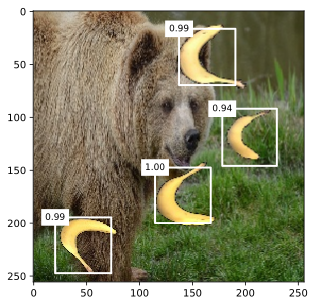

In [38]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img)
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * torch.tensor((w, h, w, h), device=row.device)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output.cpu(), threshold=0.9)